## 1D Model

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
import torch
from botorch.models import SingleTaskGP, ModelListGP
from botorch.fit import fit_gpytorch_model
from botorch.utils import standardize
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition.monte_carlo import qExpectedImprovement
from botorch.acquisition.analytic import UpperConfidenceBound, ProbabilityOfImprovement
from botorch.optim import optimize_acqf
from botorch.cross_validation import gen_loo_cv_folds
import math
import GPy

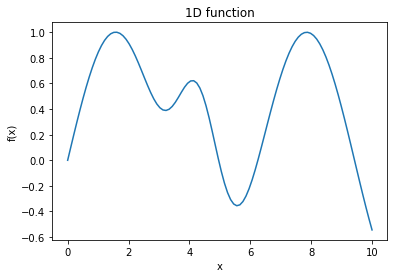

In [61]:
def f(X):
    y = []
    for x in X:
        y.append(np.sin(x) + 1.5 * np.exp(-(x - 4.3) ** 2))
    return torch.tensor(np.array(y))


bounds = np.array([[0., 10.]])
fig, ax = plt.subplots()
x = np.linspace(bounds[0, 0], bounds[0, 1], 100)
y_true = np.array([f(np.atleast_2d(xi)) for xi in x])
ax.plot(x, y_true)
ax.set_xlabel('x')
ax.set_ylabel('f(x)')
ax.set_title('1D function')
plt.show()

## Retrieve initial dataset to start with

In [62]:
def generate_init_data(n):
    train_x = torch.rand(n, 1)
    exact_objective = f(train_x).unsqueeze(-1)
    best_observation = exact_objective.max().item()
    return train_x, exact_objective, best_observation

init_data_no = 20

init_x, init_y, best_init_y = generate_init_data(init_data_no)
bounds = torch.tensor([[0.], [10.]])
print(f"intial x values:{init_x}",\
      f"initial y values:{init_y}", \
      f"Best initial y:{best_init_y}")

intial x values:tensor([[0.9388],
        [0.8869],
        [0.8441],
        [0.3322],
        [0.5532],
        [0.1604],
        [0.7755],
        [0.6646],
        [0.3245],
        [0.4329],
        [0.8476],
        [0.0194],
        [0.8957],
        [0.9325],
        [0.8174],
        [0.3808],
        [0.6322],
        [0.8599],
        [0.2329],
        [0.0359]]) initial y values:tensor([[0.8069],
        [0.7751],
        [0.7474],
        [0.3261],
        [0.5254],
        [0.1597],
        [0.7001],
        [0.6167],
        [0.3189],
        [0.4195],
        [0.7497],
        [0.0194],
        [0.7806],
        [0.8031],
        [0.7294],
        [0.3717],
        [0.5909],
        [0.7578],
        [0.2308],
        [0.0359]]) Best initial y:0.8068637847900391


## General Model

In [63]:
def generate_next_sample(init_x, init_y, bounds, n, acq):
    model = SingleTaskGP(init_x, init_y)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_model(mll)
    next_sample, _ = optimize_acqf(
        acq_function=acq,
        bounds=bounds,
        q=n,
        num_restarts=200,
        raw_samples=512,
        options={"batch_limit": 5, "maxiter": 200})
    return next_sample

## EI

In [64]:
EI = qExpectedImprovement(
    model=model,
    best_f=best_init_y)

## PI

In [65]:
def generate_next_sample(init_x, init_y, best_init_y, bounds, n):
    model = SingleTaskGP(init_x, init_y)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_model(mll)
    PI = ProbabilityOfImprovement(
        model=model,
        best_f=best_init_y)
    next_sample, _ = optimize_acqf(
        acq_function=PI,
        bounds=bounds,
        q=n,
        num_restarts=200,
        raw_samples=512,
        options={"batch_limit": 5, "maxiter": 200})
    return next_sample


n_runs = 20 # no. of BO runs
for i in range(n_runs):
    print(f"No. of optimisation runs:{i}")
    next_sample = generate_next_sample(init_x, init_y, best_init_y, bounds, n=1)
    new_result = f(next_sample).unsqueeze(-1)

    print(f"The next sample is: {next_sample}")

    init_x = torch.cat([init_x, next_sample])
    init_y = torch.cat([init_y, new_result])
    best_init_y = init_y.max().item()
    print(f"Best point performed: {best_init_y}")

No. of optimisation runs:0
The next sample is: tensor([[1.0271]])
Best point performed: 0.8558209538459778
No. of optimisation runs:1
The next sample is: tensor([[1.1324]])
Best point performed: 0.9055059552192688
No. of optimisation runs:2
The next sample is: tensor([[1.2418]])
Best point performed: 0.9464821219444275
No. of optimisation runs:3
The next sample is: tensor([[1.3448]])
Best point performed: 0.9748032689094543
No. of optimisation runs:4
The next sample is: tensor([[1.4395]])
Best point performed: 0.9918152093887329
No. of optimisation runs:5
The next sample is: tensor([[1.5243]])
Best point performed: 0.9995932579040527
No. of optimisation runs:6
The next sample is: tensor([[1.5796]])
Best point performed: 1.0008774995803833
No. of optimisation runs:7
The next sample is: tensor([[1.5891]])
Best point performed: 1.0008774995803833
No. of optimisation runs:8
The next sample is: tensor([[1.5936]])
Best point performed: 1.0008774995803833
No. of optimisation runs:9
The next s

## Result Visualisation

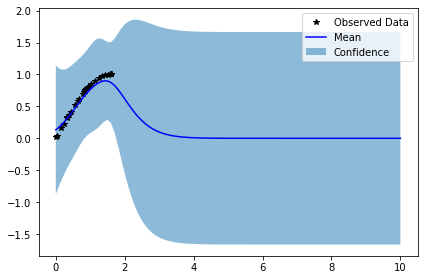

In [66]:
model = SingleTaskGP(init_x, init_y)
model.eval()

# Initialize plot
f, ax = plt.subplots(1, 1, figsize=(6, 4))
# test model on 101 regular spaced points on the interval [0, 10]
test_x = torch.linspace(0, 10, 101)
# no need for gradients
with torch.no_grad():
    # compute posterior
    posterior = model.posterior(test_x)
    # Get upper and lower confidence bounds (2 standard deviations from the mean)
    lower, upper = posterior.mvn.confidence_region()
    # Plot training points as black stars
    ax.plot(init_x.cpu().numpy(), init_y.cpu().numpy(), 'k*')
    # Plot posterior means as blue line
    ax.plot(test_x.cpu().numpy(), posterior.mean.cpu().numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5)
ax.legend(['Observed Data', 'Mean', 'Confidence'])
plt.tight_layout()
plt.show()